# Training

This notebook includes an example training loop for the models.

In [ ]:
import torch
import os
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

from model.one_model.one_stage_models import ResNet50OneStage
from data.dataset import CheXpertDataset

%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots


os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

## Datasets

In [ ]:
# Define parameter dictionary
params_transform = {
    'degree_range': (-15, 15),
    'translate': (0.1, 0.2),
    'scale': (0.2, 1.0),
    'ratio': (0.75, 1.3333333333333333),
    'gaussian_blur_kernel': 3,
    'contrast': (0.75, 1.25),
    'saturation': (0.75, 1.25),
    'brightness': (0.75, 1.25)
}

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.RandomRotation(params_transform['degree_range']),
    transforms.RandomAffine(degrees=params_transform['degree_range'], translate=params_transform['translate']),
    transforms.RandomResizedCrop(size=(224, 224), scale=params_transform['scale'], ratio=params_transform['ratio']),
    transforms.GaussianBlur(kernel_size=params_transform['gaussian_blur_kernel']),
    transforms.ColorJitter(brightness=params_transform['brightness'], contrast=params_transform['contrast'], saturation=params_transform['saturation']),
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

targets = {
            # "sex": 1,
            # "age": 2,
            # "frontal/lateral": 3,
            # "ap/pa": 4,
            # "no_finding": 5,
            # "enlarged_cardiomediastinum": 6,
            # "cardiomegaly": 7,
            # "lung_opacity": 8,
            # "lung_lesion": 9,
            # "edema": 10,
            # "consolidation": 11,
            # "pneumonia": 12,
            # "atelectasis": 13,
            # "pneumothorax": 14,
            # "pleural_effusion": 15,
            # "pleural_other": 16,
            # "fracture": 17,
            "support_devices": 18,
        }

train_dataset = CheXpertDataset(
    csv_file="./data/train.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=transform,
)
val_dataset = CheXpertDataset(
    csv_file="./data/valid.csv",
    root_dir="../image_data/",
    targets=targets,
    transform=val_transform,
)

Train dataset size: 223414
Valid dataset size: 234
Example
[1.]
torch.Size([1, 256, 256])


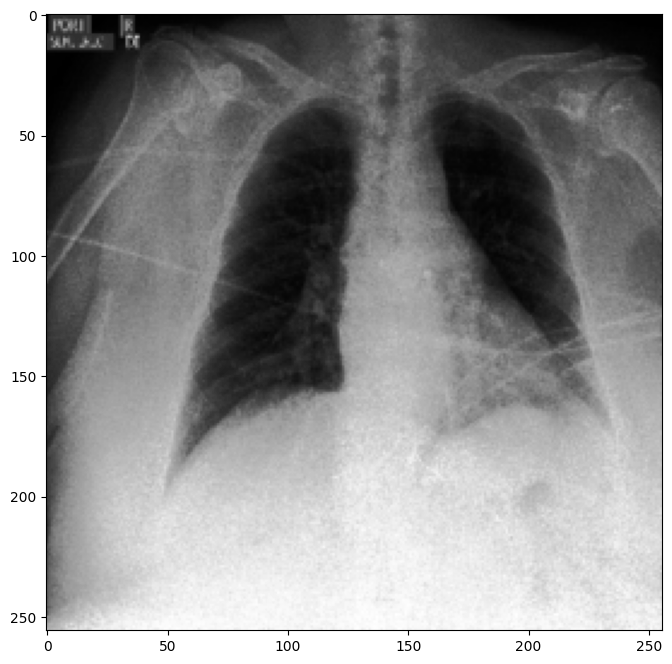

In [20]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(val_dataset)}")

print("Example")
img, labels = train_dataset[0]
print(f"{labels}")
print(f"{img.shape}")
img = img.squeeze().numpy()
plt.imshow(img, cmap='gray')

## Define model

In [ ]:
params = {
    "lr": 0.001,
    "batch_size": 16,
    "num_epochs": 1,
    "num_classes": 1,
    "input_channels": 1,
}

#TODO (FB): Add activation function to the model

loss_fn = torch.nn.BCEWithLogitsLoss()


model = ResNet50OneStage(params=params, num_classes=params['num_classes'], input_channels=params['input_channels'])

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Training

In [ ]:
"""
Train the model.
"""

#TODO (FB): Add timestamp, add model name to folder
path = os.path.join("logs", "cls_logs")
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f"run_{num_of_runs + 1}")

# Create tensorboard logger
tb_logger = SummaryWriter(path)

model.train(train_dataset, val_dataset, loss_fn, tb_logger)

#TODO (FB): Save results
model.save_model(path)

Training Epoch 1/1:   1%|█▍                                                                                                    | 200/13964 [00:34<39:06,  5.86it/s, train_loss=nan, val_loss=0.00000000]


KeyboardInterrupt: 